In [1]:
import nltk
import nltk
from nltk import word_tokenize
from nltk import WordNetLemmatizer, PorterStemmer
nltk.corpus.stopwords

<WordListCorpusReader in 'C:\\Users\\Lenovo\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('data/abcnews-date-text.csv', parse_dates=[0],
                infer_datetime_format=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226258 entries, 0 to 1226257
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   publish_date   1226258 non-null  datetime64[ns]
 1   headline_text  1226258 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 18.7+ MB


In [4]:
df.drop(['publish_date'], axis=1, inplace=True)
df.head()

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


In [5]:
stop_words = set(nltk.corpus.stopwords.words('english'))
def clean_text(head_line):
    # lower case
    head_line = head_line.lower()
    # remove digits and punctuations
    head_line = re.sub('\d|[+~`!@#$%^&*():{};''"",.<>?/\-=]','',head_line) 
    # tokenization
    tokens = word_tokenize(head_line)
    # remove stop words 
    tokens = [token for token in tokens if token not in stop_words and len(token)>3]
    # stemming
    ps = PorterStemmer()
    tokens = [ps.stem(token) for token in tokens]
    # lemmatization
    le = WordNetLemmatizer()
    tokens = [le.lemmatize(token) for token in tokens]
    # join text
    cleaned_text = " ".join(tokens)
    return clean_text

In [6]:
import re
def clean_text_v2(head_line):
#  lower case
    head_line = head_line.lower()
#  remove digits and punctuations
    head_line = re.sub('\d|[+~`!@#$%^&*():{};''"",.<>?/\-=]','',head_line) 
# tokenization
    tokens = word_tokenize(head_line)
# remove stop words 
    tokens = [token for token in tokens if token not in stop_words and len(token)>3]
# stemming
    ps = PorterStemmer()
    tokens = [ps.stem(token) for token in tokens]
# lemmatization
    le = WordNetLemmatizer()
    tokens = [le.lemmatize(token) for token in tokens]
# join text
    cleaned_text = " ".join(tokens)
    return cleaned_text

In [7]:
%time
df['headline_clean'] = df['headline_text'].apply(clean_text_v2)
%time
df

CPU times: total: 0 ns
Wall time: 0 ns


,headline_text,headline_clean
0,aba decides against community broadcasting lic...,decid commun broadcast licenc
1,act fire witnesses must be aware of defamation,fire wit must awar defam
2,a g calls for infrastructure protection summit,call infrastructur protect summit
3,air nz staff in aust strike for pay rise,staff aust strike rise
4,air nz strike to affect australian travellers,strike affect australian travel
...,...,...
1226253,what abc readers learned from 2020 looking bac...,reader learn look back year
1226254,what are the south african and uk variants of ...,south african variant covid
1226255,what victorias coronavirus restrictions mean f...,victoria coronaviru restrict mean year
1226256,whats life like as an american doctor during c...,what life like american doctor covid


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [13]:
vectorizer = CountVectorizer(max_df=0.9999, min_df=0.0001,
                            stop_words='english')
vector_text = vectorizer.fit_transform(df['headline_clean'])

In [14]:
vector_text.shape

(1226258, 5120)

In [16]:
lda_model = LatentDirichletAllocation(n_components=20,
                                     learning_method='online',
                                     max_iter=10,
                                     random_state=42)

In [18]:
%%time
lda_top = lda_model.fit_transform(vector_text)

CPU times: total: 15min 28s
Wall time: 15min 31s


In [19]:
def explore_doc(doc_index):
    print(f'Document {doc_index}:')
    for i, topic in enumerate(lda_top[doc_index]):
        print(f'\nTopic{i}: {round(topic*100,2)}%')

In [21]:
explore_doc(29)

Document 29:

Topic0: 1.0%

Topic1: 1.0%

Topic2: 1.0%

Topic3: 1.0%

Topic4: 1.0%

Topic5: 21.0%

Topic6: 1.0%

Topic7: 1.0%

Topic8: 1.0%

Topic9: 1.0%

Topic10: 1.0%

Topic11: 1.0%

Topic12: 1.0%

Topic13: 61.0%

Topic14: 1.0%

Topic15: 1.0%

Topic16: 1.0%

Topic17: 1.0%

Topic18: 1.0%

Topic19: 1.0%


In [33]:
vocab = vectorizer.get_feature_names() # all unique words in all topics
lda_components = lda_model.components_ # distribution all words in vocab in each topic
# topic word matrix, here we print out top10-frequency words in each topic
for i, component in enumerate(lda_components):
    top_idx = np.argsort(component)[::-1][:10]
    print(f'Topic {i}', np.array(vocab, dtype=np.object)[top_idx])

Topic 0 ['hospit' 'fight' 'concern' 'island' 'deal' 'close' 'offic' 'hour' 'game'
 'trade']
Topic 1 ['charg' 'south' 'north' 'flood' 'labor' 'west' 'continu' 'train' 'hope'
 'group']
Topic 2 ['say' 'fund' 'help' 'road' 'commun' 'want' 'peopl' 'leav' 'break'
 'doctor']
Topic 3 ['polic' 'death' 'trump' 'test' 'investig' 'driver' 'assault' 'green'
 'shoot' 'royal']
Topic 4 ['court' 'face' 'claim' 'trial' 'centr' 'abus' 'resid' 'beat' 'teen'
 'delay']
Topic 5 ['woman' 'urg' 'price' 'return' 'indigen' 'high' 'public' 'street'
 'commiss' 'issu']
Topic 6 ['sydney' 'chang' 'state' 'region' 'fall' 'need' 'rule' 'hill' 'polit'
 'liber']
Topic 7 ['elect' 'crash' 'final' 'bushfir' 'victim' 'inquiri' 'head' 'weather'
 'presid' 'seek']
Topic 8 ['queensland' 'child' 'hous' 'famili' 'brisban' 'govt' 'student' 'releas'
 'question' 'local']
Topic 9 ['report' 'kill' 'school' 'servic' 'alleg' 'push' 'forc' 'vote' 'premier'
 'cut']
Topic 10 ['health' 'water' 'news' 'record' 'minist' 'drug' 'power' 'budget'

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16456\3784189032.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(f'Topic {i}', np.array(vocab, dtype=np.object)[top_idx])


In [26]:
print(np.sort(lda_model.components_[10]))
print(lda_model.components_[10].size)

[5.00000000e-02 5.00000000e-02 5.00000000e-02 ... 9.93153389e+03
 1.08078792e+04 1.16948896e+04]
5120


In [32]:
vocab = vectorizer.get_feature_names()
len(vocab)

5120

In [34]:
from wordcloud import WordCloud

In [35]:
def draw_word_cloud(topic_index, num_words=50):
    component = lda_model.components_[topic_index]
    top_idx = np.argsort(component)[::-1][:num_words]
    words = np.array(vocab, dtype=np.object)[top_idx]
    
    sentence = ' '.join(words.tolist())
    wordcloud = WordCloud().generate(sentence)
    plt.figure(figsize=(10,9))
    plt.imshow(wordcloud)
    plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16456\1922195631.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  words = np.array(vocab, dtype=np.object)[top_idx]


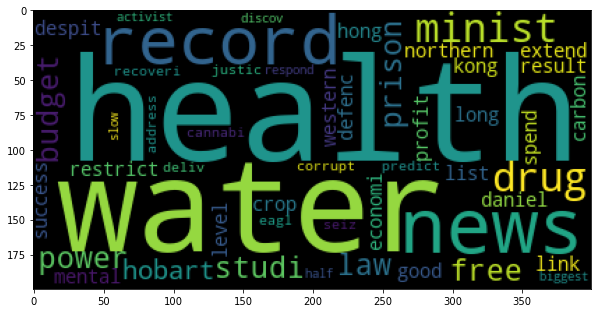

In [37]:
draw_word_cloud(topic_index=10, num_words=50);